In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
!unzip -q /content/gdrive/MyDrive/segmentation_data.zip

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
replace people_segmentation/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
n


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from skimage.morphology import remove_small_objects, remove_small_holes

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
root_dir = './people_segmentation'
image_folder = 'images'
mask_folder = 'masks'
train_list_file = 'segmentation/train.txt'
val_list_file = 'segmentation/val.txt'

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, image_folder, mask_folder, file_list):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        with open(os.path.join(root_dir, file_list), 'r') as f:
            self.file_list = f.readlines()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx].strip()
        img_path = os.path.join(self.root_dir, self.image_folder, img_name + '.jpg')
        mask_path = os.path.join(self.root_dir, self.mask_folder, img_name + '.png')

        image = Image.open(img_path)
        mask = Image.open(mask_path)
        mask = self._binarize_mask(mask)

        image = self.transform_image(image)
        mask = self.transform_mask(mask)

        return image, mask

    def transform_image(self, image):
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
        ])
        return transform(image)

    def transform_mask(self, mask):
        transform = transforms.Compose([
            transforms.Resize((256, 256), interpolation=Image.NEAREST),
            transforms.ToTensor()
        ])
        return transform(mask)

    def _binarize_mask(self, mask):
        threshold = 128
        mask = mask.point(lambda p: p > threshold and 255)
        return mask


In [ ]:
train_dataset = CustomDataset(root_dir, image_folder, mask_folder, train_list_file)
val_dataset = CustomDataset(root_dir, image_folder, mask_folder, val_list_file)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Sequential(
                  nn.Conv2d(3, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True),
                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(inplace=True))
        self.pool0 = nn.MaxPool2d(2)
        self.enc_conv1 = nn.Sequential(
                  nn.Conv2d(64, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(inplace=True),
                  nn.Conv2d(128, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(inplace=True))
        self.pool1 = nn.MaxPool2d(2)
        self.enc_conv2 = nn.Sequential(
                  nn.Conv2d(128, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)
        self.enc_conv3 = nn.Sequential(
                  nn.Conv2d(256, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())
        self.pool3 = nn.MaxPool2d(2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
                  nn.Conv2d(512, 1024, kernel_size=3, padding=1),
                  nn.BatchNorm2d(1024),
                  nn.ReLU(),
                  nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU())


        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)
        self.dec_conv0 = nn.Sequential(
                  nn.Conv2d(1024, 512, kernel_size=3, padding=1),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU())
        self.upsample1 = nn.Upsample(scale_factor=2)
        self.dec_conv1 = nn.Sequential(
                  nn.Conv2d(512, 256, kernel_size=3, padding=1),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU())
        self.upsample2 = nn.Upsample(scale_factor=2)
        self.dec_conv2 = nn.Sequential(
                  nn.Conv2d(256, 128, kernel_size=3, padding=1),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU())
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.dec_conv3 = nn.Sequential(
                  nn.Conv2d(128, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 64, kernel_size=3, padding=1),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 1, kernel_size=1))

    def forward(self, x):

        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))

        # bottleneck
        b = self.pool3(self.bottleneck_conv(e3))

        #decoder
        d0 = self.dec_conv0(torch.cat([e3, self.upsample0(b)], dim=1))
        d1 = self.dec_conv1(torch.cat([e2, self.upsample1(d0)], dim=1))
        d2 = self.dec_conv2(torch.cat([e1, self.upsample2(d1)], dim=1))
        d3 = self.dec_conv3(torch.cat([e0, self.upsample3(d2)], dim=1))
        return d3

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = UNet()
lr = 0.001
num_epoch = 25
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.to(device)

UNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    return thresholded  #

In [ ]:
def train_and_val_model(model, train_loader, val_loader, optimizer, criterion):
    model.train()
    running_train_loss = 0.0
    running_train_iou = 0.0
    total_samples = 0

    for images, masks in train_loader:
        optimizer.zero_grad()
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, masks)
        loss.backward()
        optimizer.step()

        output = torch.sigmoid(output)
        running_train_iou += iou_pytorch(output, masks).sum()
        running_train_loss += loss.item() * images.size(0)

        total_samples += images.size(0)

    running_train_loss /= total_samples
    running_train_iou /= total_samples

    model.eval()
    running_val_loss = 0.0
    running_val_iou = 0.0
    processed_data = 0

    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(images)
            loss = criterion(outputs, masks)

        outputs = torch.sigmoid(outputs)
        running_val_iou += iou_pytorch(outputs, masks).sum()
        running_val_loss += loss.item() * images.size(0)
        processed_data += images.size(0)
    running_val_loss = running_val_loss / processed_data
    running_val_iou = running_val_iou / processed_data

    return running_train_loss, running_train_iou, running_val_loss, running_val_iou

In [ ]:
history = []
for epoch in range(num_epoch):
      train_loss, train_iou, val_loss, val_iou = train_and_val_model(model, train_loader, val_loader, optimizer, criterion)
      history.append((train_loss, train_iou, val_loss, val_iou))
      print("\nEpoch {:03d} train_loss: {:0.4f} \ val_loss {:0.4f} train_iou {:0.4f} val_iou {:0.4f}".format(epoch+1, train_loss, val_loss, train_iou, val_iou))


Epoch 001 train_loss: 0.4764 \ val_loss 0.4729 train_iou 0.3428 val_iou 0.3077

Epoch 002 train_loss: 0.3980 \ val_loss 0.3949 train_iou 0.4247 val_iou 0.4682

Epoch 003 train_loss: 0.3587 \ val_loss 0.3995 train_iou 0.4697 val_iou 0.3728

Epoch 004 train_loss: 0.3363 \ val_loss 0.3512 train_iou 0.5006 val_iou 0.5275

Epoch 005 train_loss: 0.3096 \ val_loss 0.3426 train_iou 0.5389 val_iou 0.5241

Epoch 006 train_loss: 0.2859 \ val_loss 0.3080 train_iou 0.5719 val_iou 0.5346

Epoch 007 train_loss: 0.2746 \ val_loss 0.3198 train_iou 0.5913 val_iou 0.5265

Epoch 008 train_loss: 0.2554 \ val_loss 0.3040 train_iou 0.6167 val_iou 0.6000

Epoch 009 train_loss: 0.2412 \ val_loss 0.2717 train_iou 0.6361 val_iou 0.6053

Epoch 010 train_loss: 0.2309 \ val_loss 0.2332 train_iou 0.6505 val_iou 0.6426

Epoch 011 train_loss: 0.2187 \ val_loss 0.2424 train_iou 0.6649 val_iou 0.6402

Epoch 012 train_loss: 0.2137 \ val_loss 0.2484 train_iou 0.6755 val_iou 0.6107

Epoch 013 train_loss: 0.1995 \ val_loss

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
weights_path = '/content/model_weights.pth'
cool_model = UNet()
cool_model.load_state_dict(torch.load(weights_path))


<All keys matched successfully>

In [ ]:
def remove_background(model, image_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        mask = model(image_tensor)

    mask = torch.sigmoid(mask)
    mask = mask > 0.5
    mask = torch.nn.functional.interpolate(mask.float(), size=(image.height, image.width), mode='nearest')
    mask = mask.squeeze(0).squeeze(0).cpu().numpy()
    image = np.array(image)
    foreground = np.multiply(image, np.expand_dims(mask, axis=-1))
    return Image.fromarray(foreground.astype('uint8'))

In [ ]:
image_path = '/content/people_segmentation/images/adult-black-body-costume-41667.jpg'
result_image = remove_background(cool_model, image_path)

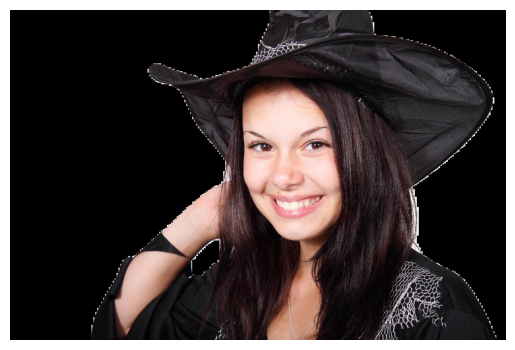

In [ ]:
plt.imshow(result_image)
plt.axis('off')
plt.show()

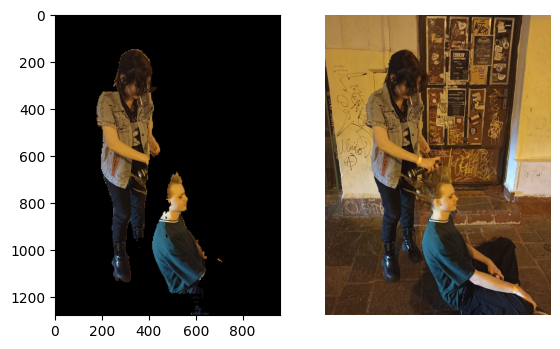

In [ ]:
image_path = '/content/4.jpg'
image = Image.open(image_path)
result_image = remove_background(cool_model, image_path)
result_image.show()
plt.subplot(1, 2, 1)
plt.imshow(result_image)
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.axis('off')
plt.show()

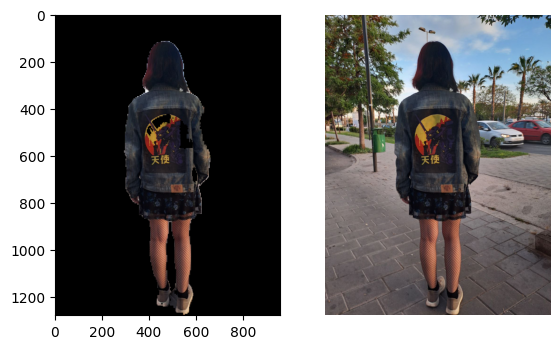

In [ ]:
image_path = '/content/2.jpg'
image = Image.open(image_path)
result_image = remove_background(cool_model, image_path)
result_image.show()
plt.subplot(1, 2, 1)
plt.imshow(result_image)
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.axis('off')
plt.show()